# KAVAK
## Airbnb price prediction

### You can find the repository with this work here:https://github.com/ArmandoLp/KAVAK

The following notebook is a test for the role of Machine Learning Engineer at KAVAK. The main target is to predict the log price using the dataset provided, it contains distinct types of data (continuous and categorical) also cantains text strings that describes the department, nevertheless because of time  I wasn't able to create a model with these data. By the way the idea for next steps will be described at the end of this notebook

I will skip the detailed preprocessing and variable analysis due to my lack of time with my current job. However, I assume that the person in charge of reviewing this notebook will understand the flow of ideas shown here.

## 1 Libraries



In [100]:
#For data process (numerical)
import pandas as pd
import numpy as np

#For the ML metodology
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MultiLabelBinarizer
#Used to try to process the noisy column 'amenities'
import json
import ast
#To plot 
import seaborn as sns
from matplotlib import pyplot as plt

#Trying with basic layers in a  NN
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
pd.set_option('display.max_columns',None)

Using TensorFlow backend.


In [2]:
train_file='./data/Work Sample/train.csv/train.csv'
test_file='./data/Work Sample/test.csv/test.csv'


## Comment
I decide to do the train test split at this point so as not to bias my model in validation, since to perform the encoding of multiple characteristics there may be elements that do not appear in the task for TEST

In [3]:
train=pd.read_csv(train_file)
test=pd.read_csv(test_file)
print("Train before split: ", train.shape)
train, val=train_test_split(train,test_size=.2, shuffle=True, random_state=21)

Train before split:  (74111, 29)


In [4]:
train.shape, val.shape

((59288, 29), (14823, 29))

## Comment
I see the information of the variables to make a quick selection on which ones need different processing

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59288 entries, 37338 to 70863
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      59288 non-null  int64  
 1   log_price               59288 non-null  float64
 2   property_type           59288 non-null  object 
 3   room_type               59288 non-null  object 
 4   amenities               59288 non-null  object 
 5   accommodates            59288 non-null  int64  
 6   bathrooms               59127 non-null  float64
 7   bed_type                59288 non-null  object 
 8   cancellation_policy     59288 non-null  object 
 9   cleaning_fee            59288 non-null  bool   
 10  city                    59288 non-null  object 
 11  description             59288 non-null  object 
 12  first_review            46517 non-null  object 
 13  host_has_profile_pic    59148 non-null  object 
 14  host_identity_verified  59148 non-

## 2 Selecting categorical features

In [6]:
columns_type=train.columns.to_series().groupby(train.dtypes).groups
columns_type={k.name: v for k,v in columns_type.items()}
columns_type

{'bool': Index(['cleaning_fee'], dtype='object'),
 'int64': Index(['id', 'accommodates', 'number_of_reviews'], dtype='object'),
 'float64': Index(['log_price', 'bathrooms', 'latitude', 'longitude',
        'review_scores_rating', 'bedrooms', 'beds'],
       dtype='object'),
 'object': Index(['property_type', 'room_type', 'amenities', 'bed_type',
        'cancellation_policy', 'city', 'description', 'first_review',
        'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
        'host_since', 'instant_bookable', 'last_review', 'name',
        'neighbourhood', 'thumbnail_url', 'zipcode'],
       dtype='object')}

In [7]:

categorical_col=train[columns_type['object']].columns
categorical_col

Index(['property_type', 'room_type', 'amenities', 'bed_type',
       'cancellation_policy', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'name',
       'neighbourhood', 'thumbnail_url', 'zipcode'],
      dtype='object')

## 3 Categorical encoding
When analyzing the variables, there are different types of categorical variables represented in different ways, we will divide them into different groups to attack the problem in a more particular way

In [8]:
categorical_col=['property_type', 'room_type', 'bed_type',
       'cancellation_policy']



### 3.1 Ordinal-One hot encoding
This first group of variables can be coded in a simple way by means of a OneHot or simple Ordinal, the criterion for not having a very dispersed dataset due to One hot, since it could create characteristics for very varied variables, we use the criterion: If the variable has more than 10 values, we will approach ordinally, otherwise One HOT will be used

In [9]:
def encoder_cat(train, categorical_col, istrain=True,imputer_val=None, encoders_val=None):
    
    encoders={}
    ordinal=[]
    one_hoted=[]
    imputer=SimpleImputer(strategy='constant', fill_value='missing')
    if istrain:
        train=pd.DataFrame(imputer.fit_transform(train), columns=train.columns)

        for i in categorical_col:



            train[i]=train[i].astype(str).str.lower()
            train[i]=train[i].astype(str).str.replace('\W', '')
            print(i,'has ', (train.groupby(i)['id'].nunique().sort_values(ascending=False).shape[0]), 'categories')
            if (train.groupby(i)['id'].nunique().sort_values(ascending=False).shape[0] == 3):
                pass

            elif (train.groupby(i)['id'].nunique().sort_values(ascending=False).shape[0] >10):
                train[i]=train[i].fillna('f')
                enc=OrdinalEncoder(handle_unknown='ignore')
                train[i]=enc.fit_transform(train[[i]])
                ordinal.append(i)
                encoders[i]=enc
            else:
                hot= OneHotEncoder(handle_unknown='ignore')
                train = train.join(pd.DataFrame(hot.fit_transform(train[[i]]).toarray(), 
                                    columns=hot.categories_[0]))
                encoders[i]=hot
                one_hoted.append(i)
            print("Correctly encoded ", i)
        return train, encoders, ordinal, one_hoted, imputer
    else:
        
        test=pd.DataFrame(imputer_val.transform(train), columns=train.columns)
        for i in categorical_col:



            train[i]=train[i].astype(str).str.lower()
            train[i]=train[i].astype(str).str.replace('\W', '')
            print(i,'has ', (train.groupby(i)['id'].nunique().sort_values(ascending=False).shape[0]), 'categories')
            if (train.groupby(i)['id'].nunique().sort_values(ascending=False).shape[0] == 3):
                pass

            elif (train.groupby(i)['id'].nunique().sort_values(ascending=False).shape[0] >10):
                train[i]=train[i].fillna('f')
                enc=encoders_val[i]
                train[i]=enc.transform(train[[i]])
                #ordinal.append(i)
                #encoders[i]=enc
            else:
                hot= encoders_val[i]
                train = train.join(pd.DataFrame(hot.transform(train[[i]]).toarray(), 
                                    columns=hot.categories_[0]))
                #encoders[i]=hot
                #one_hoted.append(i)
            #print("Correctly encoded ", i)
        return train
            
    
    

### 3.2 Numerical column
This column was originally defined as an object due to the bad insertion of data, we clean it, we impute 0 in null values and the column is ready.

In [11]:
numerical=['host_response_rate']

In [12]:
def clean_numerical(train, numerical):
    for i in numerical:
        train[i]=train[i].astype(str).str.replace("[^0-9]",'')
        train[i]=train[i].replace(r'^\s*$', '0', regex=True)
        train[i]=train[i].astype(float)
    return train

### 3.3 Date columns
This group of columns must be processed as date, however it contains many missing values, so we follow a criterion to make the imputation with its own record using the most appropriate date. For example, if we do not have a 'host since' date, we can impute the first review. Similar reasoning is used for the other two.

In [14]:
date_col=['first_review', 'host_since', 'last_review']


In [15]:
def clean_date(train, date_col=date_col):
    for i in date_col:
        train[[i]]=train[[i]].replace('missing',np.nan)
        train[i]=pd.to_datetime(train[i], errors='coerce')
    
    
    train.loc[train[date_col[0]].isnull(),date_col[0]] = train[date_col[1]]
    train.loc[train[date_col[0]].isnull(),date_col[0]] = train[date_col[2]]
    train.loc[train[date_col[1]].isnull(),date_col[1]] = train[date_col[0]]
    train.loc[train[date_col[1]].isnull(),date_col[1]] = train[date_col[2]]
    
    train.loc[train[date_col[2]].isnull(),date_col[2]] = train[date_col[0]]
    train.loc[train[date_col[2]].isnull(),date_col[2]] = train[date_col[1]]


    for i in date_col:
        train[i]=pd.to_numeric(train[i], errors='coerce')
    
    
    return train

### 3.4 Boolean values
We impute false instead of null

In [17]:
boolean=['host_has_profile_pic', 'host_identity_verified', 'instant_bookable']


In [18]:
def clean_boo(train,boolean=boolean):
    train[boolean].fillna('f',inplace=True)
    train.replace({'f':'0','t':'1','missing':'0'},inplace=True)
    
    return train
    

### 3.5 Very complex /noisy/irregular columns
In this case for amenities we decided to clean the string, since it could not be interpreted as a dictionary, we eliminated special characters and set everything to lower case. The approach that I would have done with more time would be: Extract the words, tokenize them, extract their root and pass them to vectors, in this way words that are similar or synonyms would not have distant representations in our final dataset. I would have done the same with the descriptions to identify positive and negative keywords.


In [20]:
desc_col=['name', 'description', 'thumbnail_url']
special=[ 'amenities']

In [21]:
def clean_special(df, istrain=True,mlb_val=None):
    if istrain:
        mlb = MultiLabelBinarizer(sparse_output=True)

        df[special[0]]=df[special[0]].str.replace('[^.,a-zA-Z0-9 \n\.]',"",regex=True)
        df[special[0]]=df[special[0]].str.replace(' ','')

        df[special[0]]=df[special[0]].str.lower()
        df[special[0]]=df[special[0]].str.split(',')

        df = df.join(
                    pd.DataFrame.sparse.from_spmatrix(
                        mlb.fit_transform(df[special[0]]),
                        columns=mlb.classes_))
        s=df[special[0]].explode()
        return df,mlb
    else:
        df[special[0]]=df[special[0]].str.replace('[^.,a-zA-Z0-9 \n\.]',"",regex=True)
        df[special[0]]=df[special[0]].str.replace(' ','')
        df[special[0]]=df[special[0]].str.lower()
        df[special[0]]=df[special[0]].str.split(',')
        encoders['amenities'].classes_
        
        df = df.join(
                    pd.DataFrame.sparse.from_spmatrix(
                        mlb_val.transform(df[special[0]]),
                        columns=mlb_val.classes_,index=df.index))
        return df

## 4 Preparing the data flow

In [24]:
columns_to_drop=['room_type', 'amenities', 'bed_type',
       'cancellation_policy', 'city', 'description', 'name',
       'thumbnail_url','id','neighbourhood','zipcode']

In [25]:
def prepare_data(train):
    train=train.drop(columns=columns_to_drop)
    return train.astype(float)

In [27]:
def pipeline(df,istrain=True, encoders=None,imputer=None):
    if istrain:
        train_coded, encoders, ordinal, one_hoted,imputer1=encoder_cat(df, categorical_col)
        #print(train_coded)
        train_coded=clean_numerical(train_coded, numerical)
        train_coded=clean_date(train_coded)
        train_coded=clean_boo(train_coded)
        train_coded,mlb=clean_special(train_coded)
        encoders[special[0]]=mlb
        df_t=prepare_data(train_coded)
        return df_t, encoders,imputer1
    else:
        val=encoder_cat(df, categorical_col,istrain=False, imputer_val=imputer, encoders_val=encoders)
        val=clean_numerical(val, numerical)
        val=clean_date(val)
        val=clean_boo(val)
        val=clean_special(val, istrain=False, mlb_val=encoders[special[0]])
        val=prepare_data(val)
        return val
        

# 5 Data cleaning, ready to use

In [50]:
y_train=train['log_price']
X_train=train.drop('log_price',axis=1)
y_val=val['log_price']
X_val=val.drop(['log_price'],axis=1)

In [51]:
X_train, encoders, imputer=pipeline(X_train)

property_type has  35 categories
Correctly encoded  property_type
room_type has  3 categories
Correctly encoded  room_type
bed_type has  5 categories
Correctly encoded  bed_type
cancellation_policy has  5 categories
Correctly encoded  cancellation_policy


/home/armando/.local/lib/python3.6/site-packages/pandas/core/frame.py:4322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [52]:
X_val=pipeline(X_val, istrain=False, encoders=encoders,imputer=imputer)

property_type has  28 categories
room_type has  3 categories
bed_type has  5 categories
cancellation_policy has  4 categories


/home/armando/.local/lib/python3.6/site-packages/pandas/core/frame.py:4322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [53]:
X_test=pipeline(test,istrain=False, encoders=encoders, imputer=imputer)
X_test.head()

property_type has  30 categories
room_type has  3 categories
bed_type has  5 categories
cancellation_policy has  6 categories


/home/armando/.local/lib/python3.6/site-packages/pandas/core/frame.py:4322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,property_type,accommodates,bathrooms,cleaning_fee,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds,airbed,couch,futon,pulloutsofa,realbed,flexible,moderate,strict,super_strict_30,super_strict_60,,24hourcheckin,accessibleheightbed,accessibleheighttoilet,airconditioning,airpurifier,babybath,babymonitor,babysitterrecommendations,bathtowel,bathtub,bathtubwithshowerchair,bbqgrill,beachessentials,beachfront,bedlinens,bodysoap,breakfast,buzzerwirelessintercom,cabletv,carbonmonoxidedetector,cats,changingtable,childrensbooksandtoys,childrensdinnerware,cleaningbeforecheckout,coffeemaker,cookingbasics,crib,disabledparkingspot,dishesandsilverware,dishwasher,dogs,doorman,doormanentry,dryer,elevator,elevatorinbuilding,essentials,ethernetconnection,evcharger,extrapillowsandblankets,familykidfriendly,fireextinguisher,fireplaceguards,firmmatress,firmmattress,firstaidkit,fixedgrabbarsforshowertoilet,flat,flatsmoothpathwaytofrontdoor,freeparkingonpremises,freeparkingonstreet,gameconsole,gardenorbackyard,grabrailsforshowerandtoilet,groundflooraccess,gym,hairdryer,handheldshowerhead,handorpapertowel,handsoap,hangers,heating,highchair,hostgreetsyou,hottub,hotwater,hotwaterkettle,indoorfireplace,internet,iron,keypad,kitchen,lakeaccess,laptopfriendlyworkspace,lockbox,lockonbedroomdoor,longtermstaysallowed,luggagedropoffallowed,microwave,other,otherpets,outletcovers,oven,packnplaytravelcrib,paidparkingoffpremises,pathtoentrancelitatnight,patioorbalcony,petsallowed,petsliveonthisproperty,pocketwifi,pool,privatebathroom,privateentrance,privatelivingroom,refrigerator,rollinshowerwithchair,roomdarkeningshades,safetycard,selfcheckin,shampoo,singlelevelhome,skiinskiout,smartlock,smokedetector,smokingallowed,smoothpathwaytofrontdoor,stairgates,stepfreeaccess,stove,suitableforevents,tablecornerguards,toiletpaper,translationmissingen.hostingamenity49,translationmissingen.hostingamenity50,tv,washer,washerdryer,waterfront,welllitpathtoentrance,wheelchairaccessible,wideclearancetobed,wideclearancetoshowerandtoilet,wideclearancetoshowertoilet,widedoorway,wideentryway,widehallwayclearance,windowguards,wirelessinternet
0,0.0,2.0,1.0,1.0,1.477181e+18,1.0,0.0,100.0,1.471046e+18,0.0,1.488067e+18,34.028372,-118.494449,6.0,97.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,3.0,1.0,1.0,1.473638e+18,1.0,1.0,100.0,1.386115e+18,0.0,1.476576e+18,40.720380,-73.942329,2.0,80.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,1.0,1.478995e+18,1.0,1.0,100.0,1.312243e+18,0.0,1.479341e+18,37.785434,-122.470284,2.0,100.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0

In [54]:
columns=X_train.columns

# 6 Let's start the ML process
## 6.1 Simple imputer
We use simpleImputer because I'm sure the nan values are not in the continuous value columns, since the probability that a nan value is equal to the majority is high, we use this type of imputation

In [55]:
imputer=SimpleImputer(strategy='most_frequent')

X_train=pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val=pd.DataFrame(imputer.transform(X_val), columns=X_train.columns)
X_test=pd.DataFrame(imputer.transform(X_test), columns=X_train.columns)




/home/armando/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:516: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/home/armando/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:516: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/home/armando/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:516: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/home/armando/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:516: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


### 6.2 Scaling the data
We used my preferred scaler, which, based on my experience, has had better results in regressive models.

In [56]:
from sklearn.preprocessing import MinMaxScaler


In [57]:
scalador=MinMaxScaler()
X_train=scalador.fit_transform(X_train)
X_val=scalador.transform(X_val)
X_test=scalador.transform(X_test)

In [58]:
X_train.shape, X_val.shape, X_test.shape

((59288, 157), (14823, 157), (25458, 157))

In [67]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import GridSearchCV


## 7 Model selection

I will only perform the parameter search in xgb (the most popular) due to time. However, it would be correct to carry out this procedure on all candidates. For the other models I will only train them with the default parameters. I emphasize that this is done due to lack of time.

In [72]:
xgb1 = XGBRegressor()
parameters = {
              'objective':['reg:linear'],
              'learning_rate': [.01, .1],
              'max_depth': [5,15],
              'min_child_weight': [4,8],
              'subsample': [0.5,1],
              'colsample_bytree': [0.7,.2],
              'n_estimators': [100,500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 64 candidates, totalling 128 fits
[21:59:15] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
0.6835820734478535
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_weight': 8, 'n_estimators': 500, 'objective': 'reg:linear', 'subsample': 1}


In [82]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
def rmse(targets,predictions):
    return np.sqrt(((predictions - targets.values) ** 2).mean())

In [93]:
def model(ada):
    ada.fit(X_train, y_train)
    pred_ada=ada.predict(X_val)
    pred_ada_train=ada.predict(X_train)
    #print("Score train: ", ada.score(X_train, y_train))
    #print("Score test: ", ada.score(X_val, y_val))
    print("mean_squared_error VAL: ", mean_squared_error(y_val.values, pred_ada))
    print("root_mean_squared_error VAL: ", mean_squared_error(y_val.values, pred_ada))


    dist=abs(y_val.values-pred_ada)/y_val.values
    print("Error relativo promedio[%]: ",(sum(dist)/len(dist))*100)
    

## 8 Best model
XGB has the best performance, but the results of common models will be printed just for comparison.

In [94]:
xgb_grid=XGBRegressor(**{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_weight': 8, 'n_estimators': 500, 'objective': 'reg:linear', 'subsample': 1})

In [95]:
model(xgb_grid)

[23:31:16] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
mean_squared_error VAL:  0.15492828940256845
root_mean_squared_error VAL:  0.15492828940256845
Error relativo promedio[%]:  6.0769774869956255


In [96]:
model(AdaBoostRegressor(random_state=21))


mean_squared_error VAL:  0.3593726947689159
root_mean_squared_error VAL:  0.3593726947689159
Error relativo promedio[%]:  10.279312057236126


In [97]:
model(GradientBoostingRegressor(random_state=21))

mean_squared_error VAL:  0.19234554701435375
root_mean_squared_error VAL:  0.19234554701435375
Error relativo promedio[%]:  6.9846051767937585


In [98]:
model(RandomForestRegressor(random_state=21))

mean_squared_error VAL:  0.1657690086381072
root_mean_squared_error VAL:  0.1657690086381072
Error relativo promedio[%]:  6.373098456791661


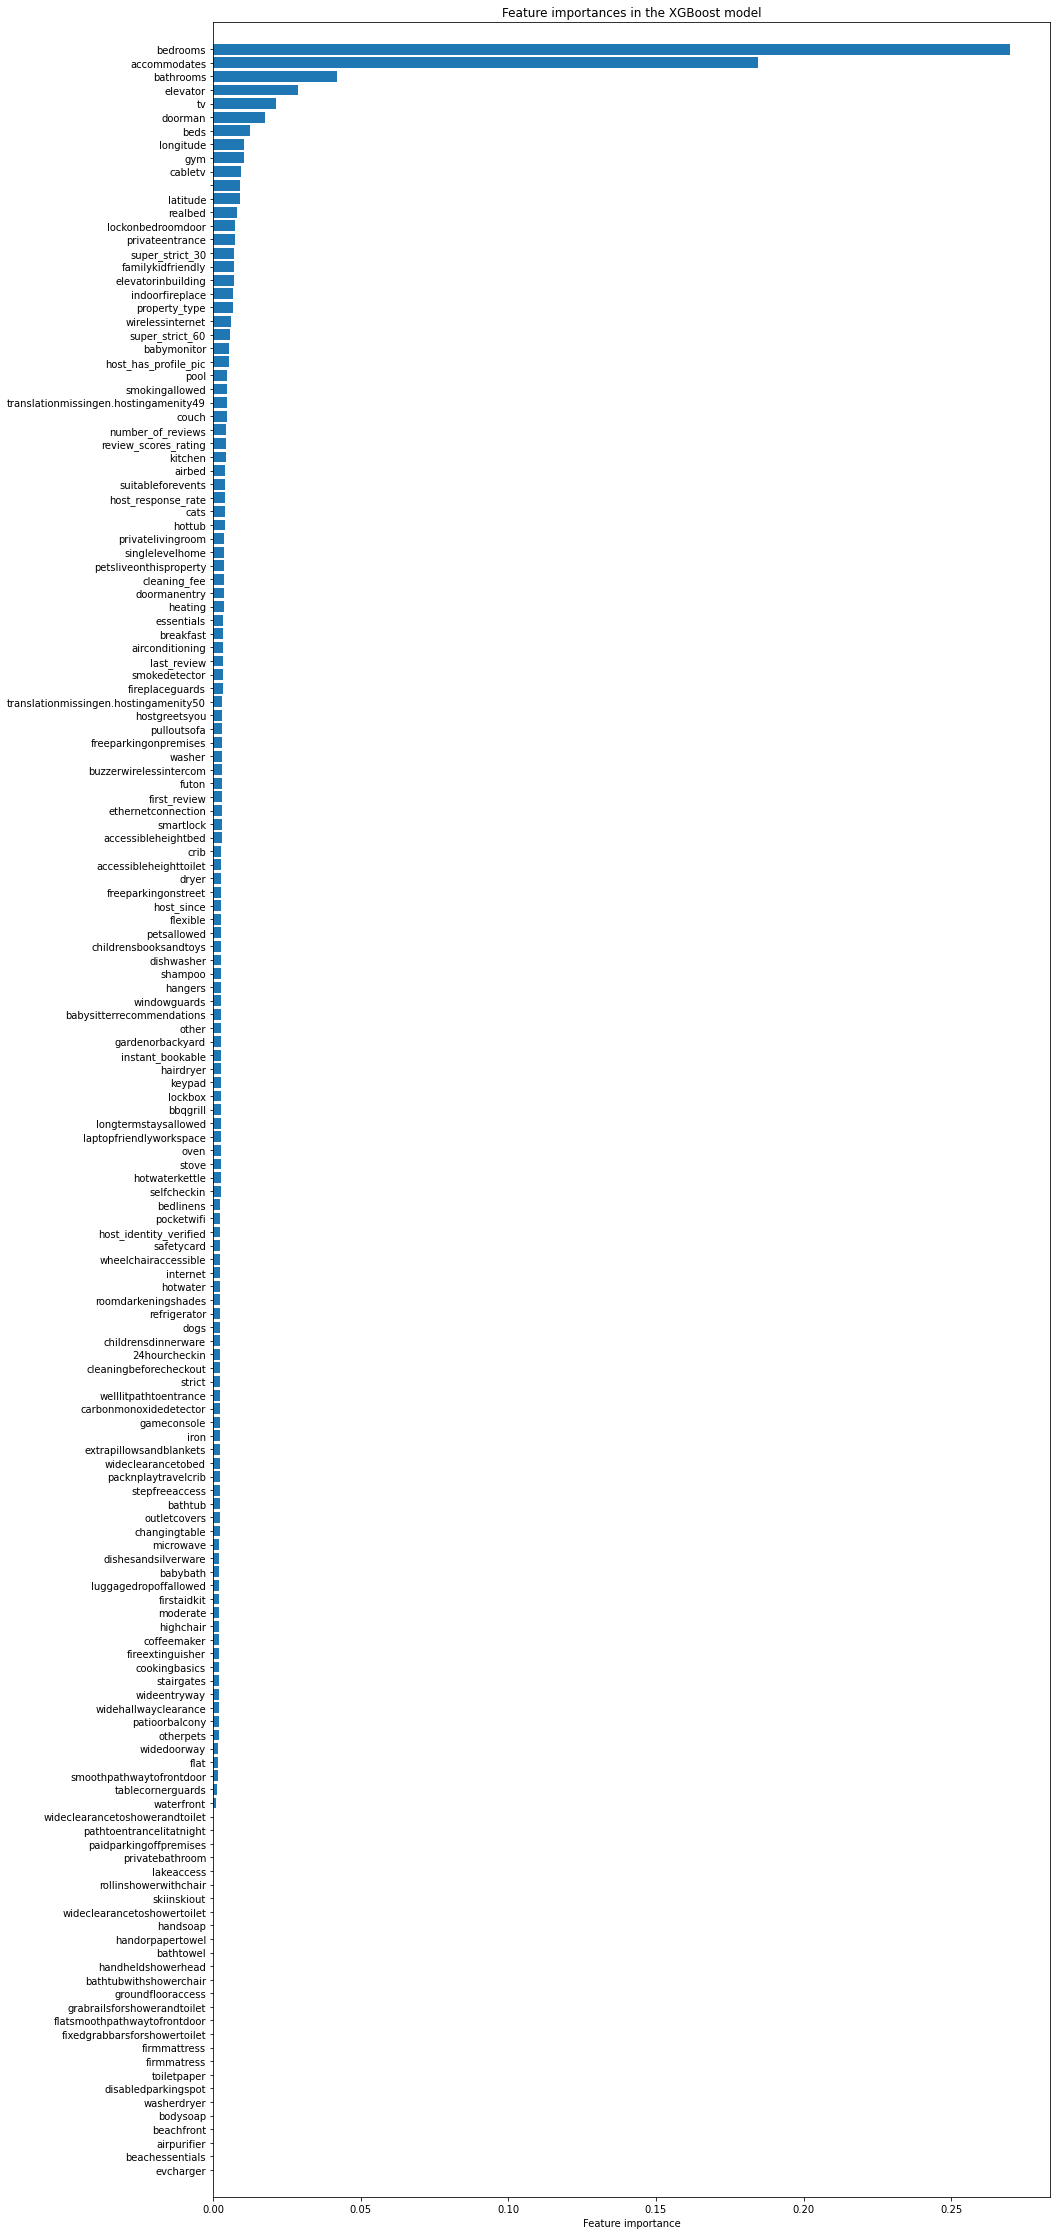

In [99]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,40))
fet=pd.DataFrame(xgb_grid.feature_importances_, columns=['weight'], index=columns).sort_values('weight')

plt.barh(fet.index, fet.weight, align='center') 
plt.title("Feature importances in the XGBoost model")
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

## 9 Testing with a basic and small NN

In [102]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers


In [112]:
nn=models.Sequential()
nn.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn.add(layers.Dense(256, activation='relu'))
nn.add(layers.Dense(256, activation='relu'))
nn.add(layers.Dense(512, activation='relu'))
nn.add(layers.Dense(1, activation='linear'))
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

nn.compile(loss='mean_squared_error', optimizer=opt,metrics=['mean_squared_error'])

In [113]:
nn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               20224     
_________________________________________________________________
dense_12 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 513       
Total params: 251,137
Trainable params: 251,137
Non-trainable params: 0
_________________________________________________________________


In [114]:
hist=nn.fit(X_train, y_train, epochs=50, batch_size=512, validation_split=.2)

Epoch 1/50
93/93 [==============================] - 4s 32ms/step - loss: 42478468.0000 - mean_squared_error: 42478468.0000 - val_loss: 0.5233 - val_mean_squared_error: 0.5233
Epoch 2/50
93/93 [==============================] - 3s 30ms/step - loss: 0.5164 - mean_squared_error: 0.5164 - val_loss: 0.5213 - val_mean_squared_error: 0.5213
Epoch 3/50
93/93 [==============================] - 3s 31ms/step - loss: 0.5177 - mean_squared_error: 0.5177 - val_loss: 0.5175 - val_mean_squared_error: 0.5175
Epoch 4/50
93/93 [==============================] - 3s 30ms/step - loss: 0.5181 - mean_squared_error: 0.5181 - val_loss: 0.5175 - val_mean_squared_error: 0.5175
Epoch 5/50
93/93 [==============================] - 3s 31ms/step - loss: 0.5169 - mean_squared_error: 0.5169 - val_loss: 0.5199 - val_mean_squared_error: 0.5199
Epoch 6/50
93/93 [==============================] - 3s 31ms/step - loss: 0.5179 - mean_squared_error: 0.5179 - val_loss: 0.5387 - val_mean_squared_error: 0.5387
Epoch 7/50
93/93 [==

# 10 Conclussions
I have a taste for NNs, however, I would have liked to try more interesting architectures with pytorch, my preferred tool, however, I don't think it is necessary to explore convolutional networks, lstm, or even transfer learning.
On the other hand, I understand that many times simpler models are better, as in this case XGB was. The result sent is the one generated by this model, since I consider that it is the one that has generalized the best.

Working with categorical data always results in a creativity challenge, however I think that as a first approach, what was done in this notebook extracts too much information from each record, which is why xgb has a very good performance.

In [122]:
xgb_grid=XGBRegressor(**{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_weight': 8, 'n_estimators': 500, 'objective': 'reg:linear', 'subsample': 1})
xgb_grid.fit(X_train, y_train)
pred=xgb_grid.predict(X_val)
pred_xgb_train=xgb_grid.predict(X_train)

print("mean_squared_error VAL: ", mean_squared_error(y_val.values, pred))
print("root_mean_squared_error VAL: ", mean_squared_error(y_val.values, pred))


dist=abs(y_val.values-pred)/y_val.values
print("Error relativo promedio[%]: ",(sum(dist)/len(dist))*100)


[01:12:24] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
mean_squared_error VAL:  0.15492828940256845
root_mean_squared_error VAL:  0.15492828940256845
Error relativo promedio[%]:  6.0769774869956255


Generamos la predicción para Test

In [123]:
y_predict_test=xgb_grid.predict(X_test)

In [124]:
result=pd.DataFrame({'id':test.id.values, 'log_price':y_predict_test})
result

,id,log_price
0,3895911,4.774456
1,9710289,4.961778
2,9051635,4.657285
3,708374,4.570852
4,626296,5.307464
...,...,...
25453,13098256,5.584315
25454,13550830,4.283690
25455,13899483,4.327939
25456,9939029,5.440010


In [125]:
result.to_csv('submission.csv',index=False)